<a href="https://colab.research.google.com/github/sayang14/Facial_Emoion_Classifiaction/blob/main/Facial_Emotion_Classification_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Component_1 
#Face Recognition: MLP

###Unzipping imported data

In [ ]:
!unzip Dataset.zip -d Dataset

Streaming output truncated to the last 5000 lines.
 extracting: Dataset/Dataset/train/sad/Training_65267116.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65275626.jpg  
 extracting: Dataset/Dataset/train/sad/Training_6529266.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65329617.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65338712.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65338797.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65387162.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65404494.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65426218.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65430136.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65437377.jpg  
 extracting: Dataset/Dataset/train/sad/Training_6545735.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65463385.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65473985.jpg  
 extracting: Dataset/Dataset/train/sad/Training_65502829.jpg  
 extra

In [ ]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2022-01-22 16:50:36--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2022-01-22 16:50:36 (34.3 MB/s) - ‘helper.py’ saved [2813/2813]



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import randint
import utils
import utils1
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import Dataset
import helper

### Transforming the input data to suitable format

In [ ]:
mean = [0.5077]
std = [0.2120]


data_dir  = '/content/Dataset/Dataset'

#transforming train data
train_transform = transforms.Compose([transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

train_dataset = datasets.ImageFolder(data_dir + '/train', transform=train_transform)
train_data =  torch.utils.data.DataLoader(train_dataset, batch_size = 100, shuffle= True)# divides the data into (total_images/bs) batches after shuffling

#transforming test data
test_transform = transforms.Compose([transforms.Resize((48,48)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))])

test_dataset = datasets.ImageFolder(data_dir + '/test', transform=test_transform)
test_data =  torch.utils.data.DataLoader(test_dataset, batch_size = 100, shuffle= True)


In [ ]:
len(test_dataset) 

7178

In [ ]:
len(train_dataset)

28709

**Code to find the mean and std of the pictures**

In [ ]:
"""def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    
    mean /= total_images_count
    std /= total_images_count
    
    return mean,std"""

In [ ]:
#get_mean_and_std(train_loader)

(tensor([0.5077]), tensor([0.2120]))

### Contructing a Three-layer neural net 

In [ ]:
class three_layer_net(nn.Module):
    def __init__(self,input_size,hidden_size1,hidden_size2,output_size):
        super(three_layer_net,self).__init__()
        
        self.layer1 = nn.Linear( input_size , hidden_size1, bias=True)
        self.layer2 = nn.Linear( hidden_size1 , hidden_size2, bias=True)
        self.layer3 = nn.Linear( hidden_size2, output_size, bias = True)
        
    def forward(self, x):
        y       = self.layer1(x)
        y_hat   = torch.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = torch.relu(z) 
        scores  = self.layer3(z_hat)
        
        return scores

### Building the neural net using the template contructed above

In [ ]:
neural_net = three_layer_net(2304,100,100,7)
neural_net.to("cuda")   #transferring the neural net onto the GPU
print(neural_net)

three_layer_net(
  (layer1): Linear(in_features=2304, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=7, bias=True)
)


In [ ]:
for n, p in neural_net.named_parameters():    #checking whether the neural net is transferred onto the gpu
    print(p.device, '', n)

cuda:0  layer1.weight
cuda:0  layer1.bias
cuda:0  layer2.weight
cuda:0  layer2.bias
cuda:0  layer3.weight
cuda:0  layer3.bias


### Selecting loss,optimizer batch size, learning rate 

In [ ]:
#Selecting the loss function
criterion = nn.CrossEntropyLoss()
#Selecting the optimizer
optimizer = torch.optim.SGD( neural_net.parameters() , lr=0.03 ) 
#Defining batch size
bs= 100

### Evaluates on test data and gives error 

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,7178,bs):

        test_data =  torch.utils.data.DataLoader(test_dataset, batch_size = bs, shuffle= True)
        test_images,test_labels = next(iter(train_data))
        test_images = test_images.view(bs,48,48)

        inputs = test_images.view(bs,2304)

        scores = neural_net( inputs.to("cuda") ) 

        error = utils.get_error(scores ,test_labels)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

### Training the neural network

In [ ]:
start = time.time()

for epoch in range(300):
    
    if epoch == 200:
      optimizer = torch.optim.SGD( neural_net.parameters() , lr=0.006 )   # it was observed that the error starts increasing with a lr of 0.03 after 200 epochs


    running_error=0
    num_batches=0
    
    
    for count in range(0,28709,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        batch_images,batch_labels = next(iter(train_data))     #everytime next() function is called it moves to the next batch and therefore iterates throughout the train_data set
        batch_images = batch_images.view(bs,48,48)

        inputs = batch_images.view(bs,2304)

        inputs.requires_grad_()

        scores= neural_net(inputs.to("cuda")) 

        loss =  criterion(scores ,batch_labels.to("cuda")) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
     
        error = utils.get_error( scores.detach() , batch_labels.to("cuda"))
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 10 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, '\t time=', elapsed_time,'\t error=', total_error*100 ,'percent') 
               

 
epoch= 0 	 time= 17.021608591079712 	 error= 67.61111172123087 percent
 
epoch= 10 	 time= 182.33561038970947 	 error= 53.66666751603285 percent
 
epoch= 20 	 time= 347.36742782592773 	 error= 47.5972230028775 percent
 
epoch= 30 	 time= 513.3918793201447 	 error= 43.079862371087074 percent
 
epoch= 40 	 time= 679.1966776847839 	 error= 38.95486241413487 percent
 
epoch= 50 	 time= 844.6388919353485 	 error= 35.03819598505895 percent
 
epoch= 60 	 time= 1009.836630821228 	 error= 31.41666826688581 percent
 
epoch= 70 	 time= 1174.8324837684631 	 error= 29.28472397228082 percent
 
epoch= 80 	 time= 1339.9887599945068 	 error= 26.378474032713306 percent
 
epoch= 90 	 time= 1504.6522347927094 	 error= 24.395835171971054 percent
 
epoch= 100 	 time= 1668.7860000133514 	 error= 22.013890950216187 percent
 
epoch= 110 	 time= 1833.3005211353302 	 error= 19.892363250255585 percent
 
epoch= 120 	 time= 1997.8555572032928 	 error= 18.038196654783356 percent
 
epoch= 130 	 time= 2163.211751937

In [ ]:
eval_on_test_set()  #checks error on test set, if error on test is more than train then check for over-fitting

###Displaying the test image and the respective classification by the neural net

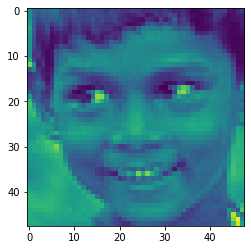

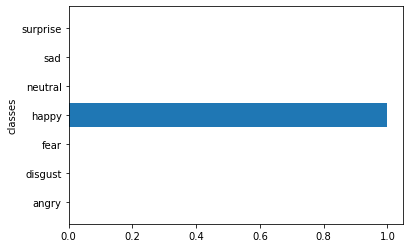

In [ ]:
import numpy as np
import utils1
neural_net.to('cpu')

indx = randint(0,7178-1)
images, labels = next(iter(test_data))
im = images[0]

arr = images[0].numpy()
arr_ = np.squeeze(arr) 
plt.imshow(arr_)
plt.show()
with torch.no_grad():
  scores = neural_net(im.view(1,2304))
  prob=torch.softmax(scores, dim = 1)

prob = prob.view(7).numpy().tolist()     #converting the probabilities array into 

classes = ["angry","disgust","fear", "happy", "neutral", "sad", "surprise"]


plt.barh(classes, prob)
 
# setting label of y-axis
plt.ylabel("classes")
 
# setting label of x-axis
plt.show()


**CNN Part**

In [ ]:
import matplotlib.pyplot as plt
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import utils

import pandas as pd
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

**Calculating Mean and Standard Deviation**

In [ ]:
# def get_mean_and_std(loader):
#   mean=0
#   std=0
#   tot_images_count=0
#   for images, _ in loader:
#     image_count_in_a_batch = images.size(0)
#     # print(images.shape)
#     images = images.view(image_count_in_a_batch, images.size(1), -1)
#     mean += images .mean(2).sum(0)
#     std += images.std(2).sum(0)
#     tot_images_count += image_count_in_a_batch
#   mean /= tot_images_count
#   std /= tot_images_count

#   return mean, std
  
# get_mean_and_std(train)

In [ ]:
mean =[0.5334, 0.5334, 0.5334]
std = [0.1774, 0.1774, 0.1774]

data_dir = '/content/Dataset/Dataset'
transform = transforms.Compose([
        #transforms.RandomRotation(20),
        transforms.RandomResizedCrop(128),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))])
batch_size = 100
train_set = datasets.ImageFolder(data_dir + '/train',transform = transform)
test_set =  datasets.ImageFolder(data_dir + '/test',transform = transform)

train = torch.utils.data.DataLoader(train_set,batch_size =batch_size,shuffle=True,num_workers=2)
test = torch.utils.data.DataLoader(test_set,batch_size =batch_size,shuffle=True,num_workers=2)

classes = ('angry', 'disgust', 'fear', 'happy','neutral', 'sad', 'surprise')

print(len(train))
print(len(test))
print(len(train_set))
print(len(test_set))

288
72
28709
7178


**Checking If its loaded properly**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


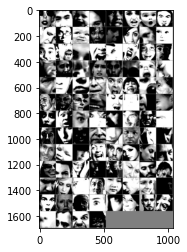

neutral neutral happy happy happy fear  surprise disgust fear  angry fear  fear  neutral surprise fear  neutral surprise angry neutral fear  happy angry happy fear  sad   surprise happy fear  neutral neutral surprise sad   fear  sad   neutral sad   surprise happy sad   angry neutral angry fear  happy surprise surprise sad   happy fear  surprise angry angry neutral disgust angry neutral sad   fear  happy angry fear  neutral sad   sad   happy happy neutral happy surprise happy sad   happy happy angry sad   sad   fear  sad   sad   neutral angry neutral happy surprise neutral sad   happy angry surprise sad   neutral surprise fear  happy sad   happy surprise sad   angry happy


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**Preparing The CNN Training Net**

In [ ]:
class LeNet_convnet(nn.Module):

    def __init__(self):

        super(LeNet5_convnet, self).__init__() 
        self.conv1 = nn.Conv2d(3,  50,  kernel_size=3,  padding=1 )
        BatchNorm2d(6)
        self.pool1  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(50,  100,  kernel_size=3,  padding=1 )
        BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(100,  200,  kernel_size=3,  padding=1 )
        BatchNorm2d(200)
        self.pool3 = nn.MaxPool2d(2,2)

        # linear layers
        self.linear1 = nn.Linear(51200, 500)
        self.linear2 = nn.Linear(500,200)
        self.linear3 = nn.Linear(200,50)
        self.linear4 = nn.Linear(50,7)
        self.dropout = nn.Dropout(0.25)


    def forward(self, x):

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = x.view(-1, 51200)
        # x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.linear4(x)
    
        return x

In [ ]:
net=LeNet5_convnet()
# net = Net()
print(net)
utils.display_num_param(net)

LeNet5_convnet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=51200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=50, bias=True)
  (linear4): Linear(in_features=50, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)
There are 25937807 (25.94 million) parameters in this neural network


**Checking availability of GPU** 

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


**Send the weights of the networks to the GPU as well as choosing the criterion and learning rate** 

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,momentum = 0.9)

if torch.cuda.is_available(): # Checking if we can use GPU
    net = net.cuda()
    criterion = criterion.cuda()
net.to(device)
# print(net)

LeNet5_convnet(
  (conv1): Conv2d(3, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=51200, out_features=500, bias=True)
  (linear2): Linear(in_features=500, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=50, bias=True)
  (linear4): Linear(in_features=50, out_features=7, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

**Training the network**

In [ ]:
def train_net(n_epoch): # Training our network
    losses = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            
            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            if i % 100 == 99:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    plt.plot(losses, label='Training loss')
    plt.show()
    print('Finished Training')
train_net(50)

**Saving The Trained Model**

In [ ]:
PATH = './test_data_2.pth'
torch.save(net.state_dict(), PATH)

# Loading the trained network
# net.load_state_dict(torch.load(PATH))

**Testing the Trained Model**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


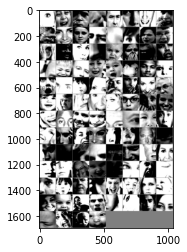

GroundTruth:  surprise happy angry sad   neutral fear  happy fear  sad   happy sad   angry happy surprise angry fear  fear  happy happy sad   sad   sad   fear  neutral fear  sad   sad   sad   surprise neutral neutral surprise surprise angry sad   happy sad   fear  happy angry happy angry neutral fear  fear  surprise fear  happy fear  sad   happy sad   happy happy sad   surprise happy fear  angry happy surprise neutral neutral sad   sad   neutral neutral neutral surprise fear  angry surprise neutral neutral happy happy neutral angry fear  angry sad   surprise angry fear  angry surprise neutral happy happy happy fear  disgust fear  neutral angry happy sad   fear  neutral angry


In [ ]:
dataiter = iter(test)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(100)))

In [ ]:
# net = Net()
net=LeNet5_convnet()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(100)))

Predicted:  surprise happy sad   sad   sad   neutral happy sad   neutral happy neutral sad   happy neutral happy surprise sad   happy sad   happy angry sad   sad   neutral happy happy happy happy surprise neutral neutral surprise surprise surprise neutral happy neutral fear  happy happy happy sad   surprise happy sad   surprise fear  happy happy surprise happy sad   happy happy sad   surprise happy sad   happy happy neutral sad   neutral neutral neutral neutral sad   sad   angry sad   surprise happy sad   neutral happy happy neutral happy angry happy surprise surprise sad   sad   angry surprise neutral sad   happy happy sad   angry happy sad   neutral happy sad   surprise happy angry


**Overall Accuracy with 50 epochs** 

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test:
        images, labels = data
        # images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 48 %


**Classwise Accuracy** 

In [ ]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: angry is 30.1 %
Accuracy for class: disgust is 13.5 %
Accuracy for class: fear  is 15.0 %
Accuracy for class: happy is 72.8 %
Accuracy for class: neutral is 58.3 %
Accuracy for class: sad   is 42.7 %
Accuracy for class: surprise is 60.3 %
